## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string

import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob

import statistics as st

from wordcloud import WordCloud, STOPWORDS

!pip3 install gensim==3.8.3

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from sklearn.decomposition import NMF

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 

f = open('/content/gdrive/MyDrive/Colab Notebooks/Case Study Automatic Ticket Classification/complaints.json')# Write the path to your data file and load it 
 
# returns JSON object as  
# a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
# View the dimensions of dataframe
df.shape

(78313, 22)

In [ ]:
#some more information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

There are 78313 complaints and 22 features in the data. 

In [ ]:
#print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

The column names are changed due to normalization of the JSON and will have to be renamed suitably.

In [ ]:
#Assign new column names
# Remove the leading underscores from all column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)
#Further remove 'source' from column names beginning with 'source.'
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)
#View the dataframe with renamed columns
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#The customer complaint is in "complaint_what_happened" column.Let us count the number of blank rows under this column 

len(df[df['complaint_what_happened'] == ""])


57241

So there are 57241 number of blank rows under the "complaint_what_happened" column and have to be removed.

In [ ]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [ ]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

## View the shape of modified dataframe
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [ ]:
## Let us view the first five rows of complaint column

pd.set_option("display.max_colwidth",-1)
df['complaint_what_happened'].head()

1     Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
# The function  to clean the text and remove all the unnecessary elements.

def clean_text(text):
    
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    #text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [ ]:
#The clean text function is applied to the complaint column and a new dataframe is created containing text-cleaned complaints
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))

# View first five rows of text-cleaned dataframe
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


In [ ]:
#The function to Lemmatize the texts

def lemmatizer(text):     
        
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)


In [ ]:
#A dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

# We add a column for lemmatized complaints to the text cleaned dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)


In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
#df_clean -> 2 cols { complaints; lemmatized_complaints}
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately contact chase bank within no more than of get the notification on the screen and i be tell by the chase represent

In [ ]:
#Write your function to extract the POS tags 

#We are interested in finding topics, which are mostly nouns. Hence we wish to extract nouns from the lematized text
# Extracting nouns

def get_nouns(text):
        
    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])


In [ ]:
# The function to create a new column containing only nouns 

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_nouns(x['lemmatized_complaint']), axis=1)



In [ ]:
# Vieing the clean dataframe
# It should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come acro

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:


# Write your code here to visualise the data according to the 'Complaint' character length

# Let us create a list of lengths of pre-processed complaints

doc_lens = [len(doc) for doc in df_clean['complaint_POS_removed']]

print(doc_lens[0:10])

print('Median =',st.median(doc_lens))


[192, 102, 74, 446, 192, 7, 699, 652, 1322, 51]
Median = 329.0


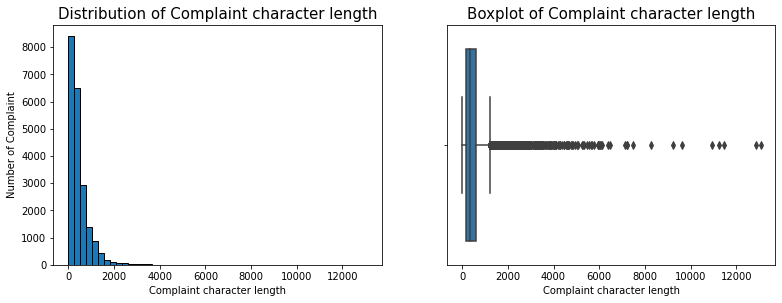

In [ ]:
# Plot the data according to character length of complaints
plt.figure(figsize=(20,15))
ax1 = plt.subplot(3,3, 1)
plt.hist(doc_lens, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=15)
plt.ylabel('Number of Complaint', fontsize=10)
plt.xlabel('Complaint character length', fontsize=10)

ax2 = plt.subplot(3, 3, 2)
sns.boxplot(x=doc_lens)
plt.title('Boxplot of Complaint character length', fontsize=15)
plt.xlabel('Complaint character length', fontsize=10)

plt.show()

The distribution of the word counts is a normal distribution skewed on the positive side.
The median of the complaint character length is 329. 

#### Find the top 40 words by frequency among all the articles after processing the text.

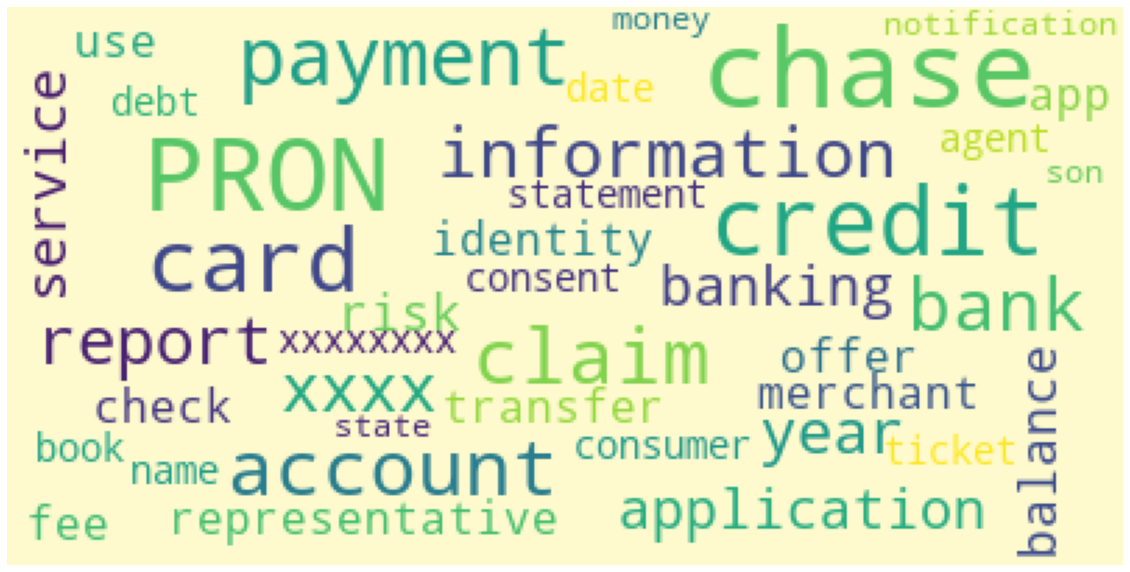

In [ ]:


#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# We now find the n top Ngram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_Ngram(N, text, n):
    
    vec = CountVectorizer(ngram_range =(N, N), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    freq_words = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_freq_words =sorted( freq_words, key = lambda x: x[1], reverse=True)
    return  sorted_freq_words[:n]

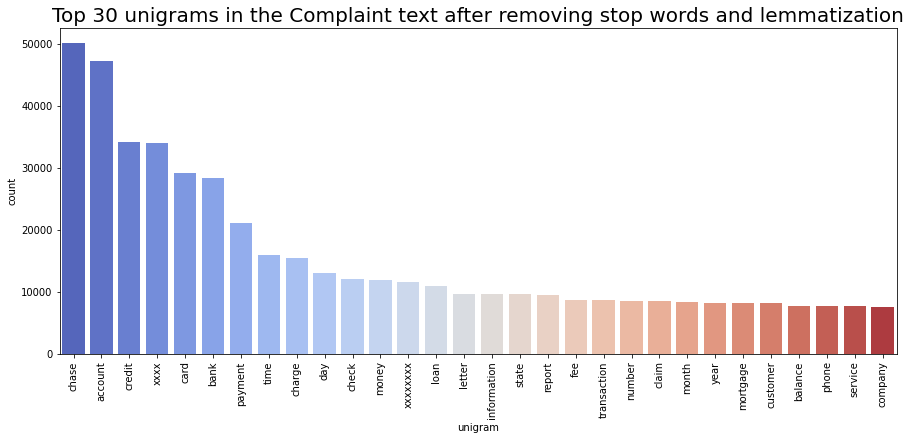

In [ ]:

# Top 30 unigrams by frequency among all the complaints
common_words = get_top_Ngram(1, df_clean['Complaint_clean'].values.astype('U'), 30)
df1 = pd.DataFrame(common_words, columns = ['unigram', 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df1, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()


In [ ]:
#Print the top 10 words in the unigram frequency

df1.head(10)


,unigram,count
0,chase,50015
1,account,47168
2,credit,34149
3,xxxx,34013
4,card,29071
5,bank,28392
6,payment,21159
7,time,16025
8,charge,15539
9,day,12970


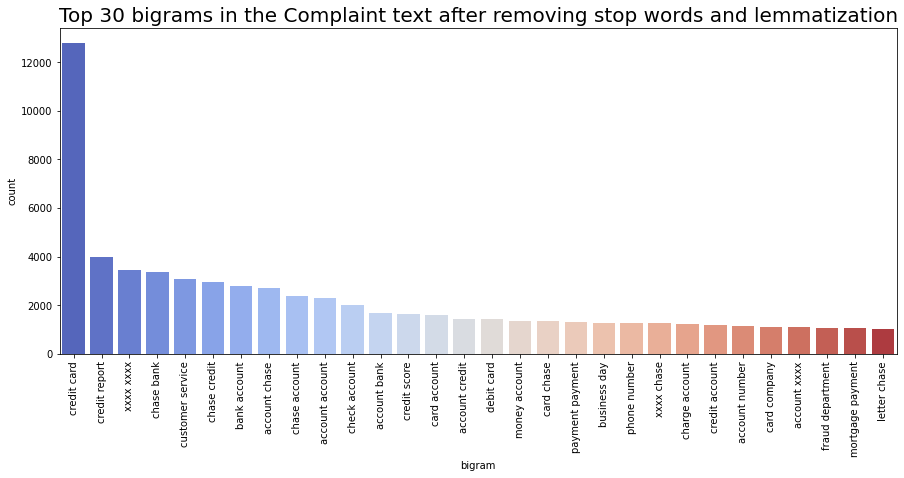

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# Top 30 bigrams by frequency among all the complaints
common_words = get_top_Ngram(2, df_clean['Complaint_clean'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['bigram', 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x= 'bigram', y= 'count', data= df2, palette= "coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency

df2.head(10)

,bigram,count
0,credit card,12773
1,credit report,3979
2,xxxx xxxx,3451
3,chase bank,3379
4,customer service,3078
5,chase credit,2946
6,bank account,2774
7,account chase,2698
8,chase account,2386
9,account account,2288


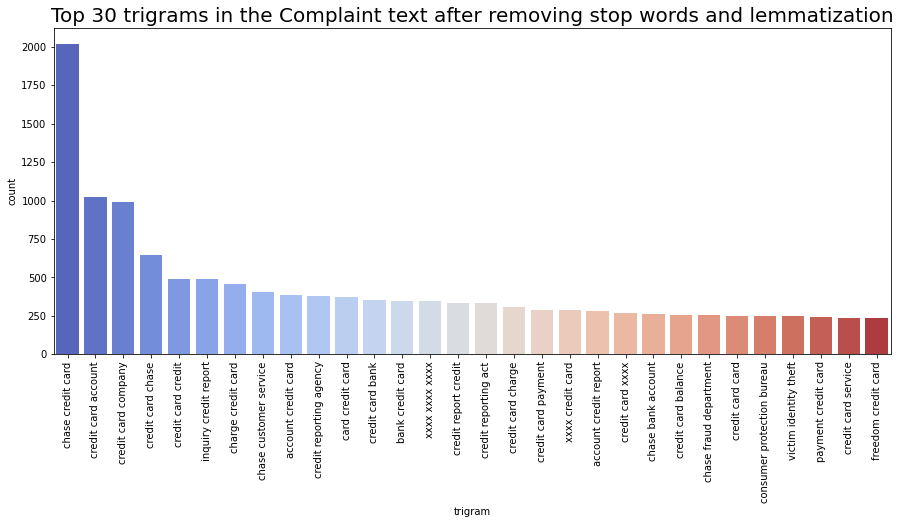

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# Top 30 trigrams by frequency among all the complaints
common_words = get_top_Ngram(3, df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['trigram', 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [ ]:
#Print the top 10 words in the trigram frequency

df3.head(10)

,trigram,count
0,chase credit card,2021
1,credit card account,1022
2,credit card company,990
3,credit card chase,644
4,credit card credit,493
5,inquiry credit report,489
6,charge credit card,458
7,chase customer service,407
8,account credit card,386
9,credit reporting agency,381


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the ch

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 

# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
#To select best number of Topics, we will use Coherence Model 

In [ ]:
#With the Coherence Model we will see how to automatically select the best number of topics.



In [ ]:


df_clean['processed_text'] = df_clean['Complaint_clean'].apply(word_tokenize) 
texts = df_clean['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)


Bag of words representation

In [ ]:
# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

How to decide the number of topics?
- By using the Coherence score approach

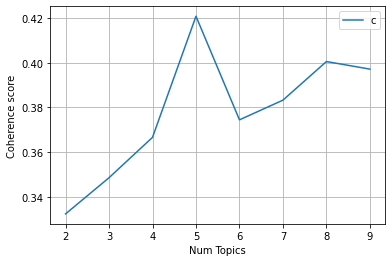

Optimal num of topics = 5


In [ ]:


# Using Gensim's NMF to get the best num of topics via coherence score

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(2,10,1))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

plt.plot(topic_nums, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

print('Optimal num of topics =',best_num_topics)


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Loading the nmf_model with the n_components i.e 5

num_topics = 5 #write the value you want to test out

#keep the random_state =40

nmf_model = NMF(n_components=num_topics, random_state=40) 

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7401

In [ ]:
#Print the Top15 words for each of the topics

for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')


THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['car', 'year', 'chase', 'account', 'credit', 'date', 'auto', 'time', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'dispute', 'transaction', 'chase', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)


array([4, 1, 1, ..., 3, 2, 2])

In [ ]:
#Assign the best topic to each of the complaints in Topic Column
# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_results.argmax(axis=1)


In [ ]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,processed_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,"[morning, name, stop, bank, cardmember, service, ask, debt, verification, statement, i, bank, debt, mail, month, attempt, debt, i, right, information, consumer, chase, account, thank, advance, help]",4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,"[i, card, agent, upgrade, date, agent, information, order, account, change, date, consent, recording, agent]",1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,"[card, report, application, identity, consent, service, credit, identity, applicant]",1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,processed_text,Topic
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen check number xxxx claim number be xxxx with chase,son check deposit -PRON- chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,"[son, check, deposit, chase, account, fund, chase, bank, account, money, son, check, money, chase, bank, refuse, money, son, call, chase, time, i, check, owner, country, time, date, check, number, claim, number, chase]",0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday on thursday i go

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

After looking carefully at the first 5 complaints for each topics, we can assign names to topics as below

    Topic 0: Bank Account services
    Topic 1: Credit card or prepaid card
    Topic 2: Others
    Topic 3: Theft/Dispute Reporting
    Topic 4: Mortgage/Loan


In [ ]:
#Creating the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,processed_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,"[morning, name, stop, bank, cardmember, service, ask, debt, verification, statement, i, bank, debt, mail, month, attempt, debt, i, right, information, consumer, chase, account, thank, advance, help]",Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,"[i, card, agent, upgrade, date, agent, information, order, account, change, date, consent, recording, agent]",Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,"[card, report, application, identity, consent, service, credit, identity, applicant]",Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Creating the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

#Replacing Topics with Topic Names

df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,processed_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,"[morning, name, stop, bank, cardmember, service, ask, debt, verification, statement, i, bank, debt, mail, month, attempt, debt, i, right, information, consumer, chase, account, thank, advance, help]",4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,"[i, card, agent, upgrade, date, agent, information, order, account, change, date, consent, recording, agent]",1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,"[card, report, application, identity, consent, service, credit, identity, applicant]",1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first

In [ ]:
#Keeping the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaint_what_happened","Topic"]]

In [ ]:
training_data.shape


(21072, 2)

In [ ]:
#Viewing the distribution of target variable Topic

# Value counts of the five topics
training_data['Topic'].value_counts()



0    5164
1    5006
3    4819
4    3852
2    2231
Name: Topic, dtype: int64

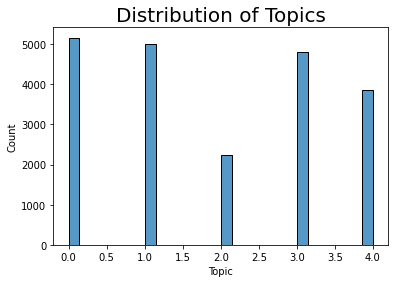

In [ ]:
# Plot a histogram of classes (i.e. topics)
sns.histplot(data=training_data, x='Topic')
plt.title("Distribution of Topics", fontsize=20)
plt.show()

Selection of Evaluation Metric

    As the distribution of target variable is not normal and there is imbalance of classes, we select F1 Score as our evaluation metric for comparing the performance of various models we will build.
    Moreover, we will use a weighted average method for evaluating F1 Score due to the imbalance of classes


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Writing the code to get the Vector count

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

#Writing the code to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [ ]:

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33599)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33599)
Shape of y_test: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
#Creating a function to evaluate the classifiers

def eval_model(y_test, y_pred, model_name):       
  
    print(f"Classification Report for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"Confusion Matrix for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return



Write your code here to build any 3 models and evaluate them using the required metrics


Model #1: Logistic Regression 


In [ ]:
# Run the Logistic Regression model
model_name = 'Logistic Regression'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 7.63 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9225620327108923

In [ ]:
# Hyperparameter tuning to improve Logistic Regression performance

param_grid_lr = {
    'penalty': ['l1', 'l2','elasticnet', 'none'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['saga']
}

grid_lr = GridSearchCV(estimator=clf_lr, 
                       param_grid=param_grid_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)

%time
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 6.91 µs
Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


 Best Estimator parameters

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9434003190687049

Classification Report for Logistic Regression(tuned)

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.96      1303
Credit card or prepaid card       0.95      0.95      0.95      1290
                     Others       0.93      0.95      0.94       548
    Theft/Dispute Reporting       0.93      0.92      0.93      1204
              Mortgage/Loan       0.93      0.95      0.94       923

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



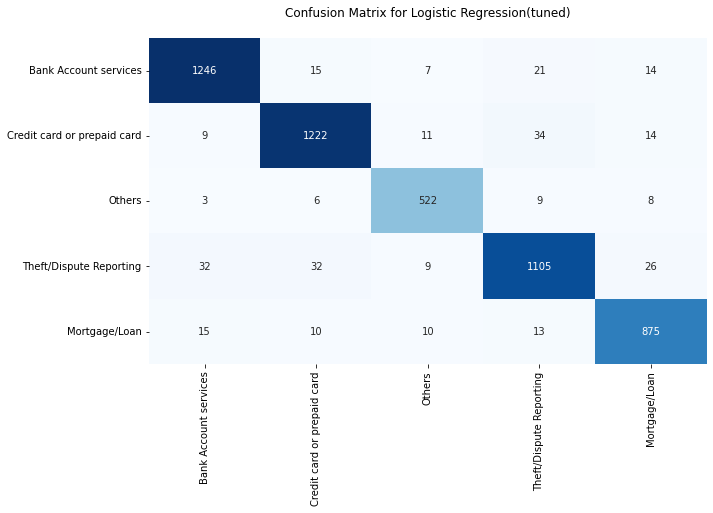

In [ ]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, 'Logistic Regression(tuned)')


 The tuned Logistic Regression model gives a pretty high F1 score of 0.94.
 This model performs well on all topics.


In [ ]:
# Creating a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94



Model #2: Decision Tree 


In [ ]:
# Run Decision Tree on default hyperparameters
model_name = 'Decison Tree'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7777001667747023

In [ ]:
# Hyperparameter tuning to improve Decision Tree performance
param_grid_dt = {
     'criterion': ['gini', 'entropy'],
     'max_depth' : [10, 20, 30, 40],
     'min_samples_split' : [5, 10, 20, 30],
    'min_samples_leaf' : [ 2, 5, 10, 15],
    'max_features':['log2','sqrt',None],
}
 
grid_dt = GridSearchCV(estimator=clf_dt, 
                        param_grid=param_grid_dt,
                        verbose=1,
                        scoring='f1_weighted',
                        n_jobs=-1,
                        cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 30}



Best Estimator parameters

{'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 15}

In [ ]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth = 30, 
                                      min_samples_split = 30,
                                      min_samples_leaf = 10, 
                                      max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned



0.800125484343421

Classification Report for Decision Tree(tuned)

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.81      0.81      1303
Credit card or prepaid card       0.83      0.83      0.83      1290
                     Others       0.80      0.77      0.79       548
    Theft/Dispute Reporting       0.77      0.75      0.76      1204
              Mortgage/Loan       0.80      0.83      0.82       923

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



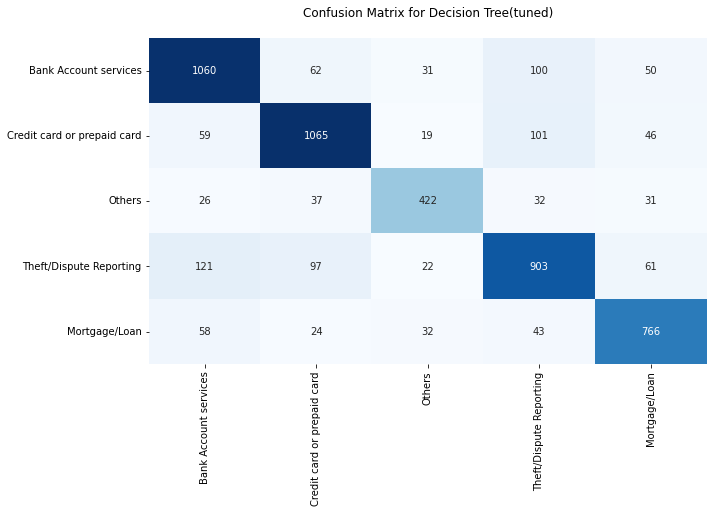

In [ ]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, 'Decision Tree(tuned)')


 The tuned Decision Tree model gives a decent F1 score of 0.80.
 However, this model is not able to perform well on classifying Others and Theft/Dispute Reporting topics.


In [ ]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94
1,Decision Tree,0.78,0.80


Model #3: Random Forest 

In [ ]:
# Run the Random Forest model on default hyperparameters
model_name = 'Random Forest'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8105785725743457

In [ ]:
# Hyperparameter tuning to improve Random Forest performance
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'criterion':['gini','entropy'],
    'max_depth': [10, 20, 30,40],
    'min_samples_split': [10, 20, 25, 30],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': ['log2', 'sqrt', None]    
}

grid_rf = RandomizedSearchCV(estimator=clf_rf, 
                       param_distributions=param_grid_rf,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1,
                       cv=5)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 30, 'criterion': 'gini'}


Best Estimator parameters

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}

In [ ]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=300, 
                                      min_samples_split=20, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=10, 
                                      criterion='gini'
)
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8149325328033142

Classification Report for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.83      0.83      1303
Credit card or prepaid card       0.85      0.83      0.84      1290
                     Others       0.83      0.80      0.81       548
    Theft/Dispute Reporting       0.79      0.75      0.77      1204
              Mortgage/Loan       0.79      0.87      0.83       923

                   accuracy                           0.82      5268
                  macro avg       0.82      0.82      0.81      5268
               weighted avg       0.82      0.82      0.81      5268



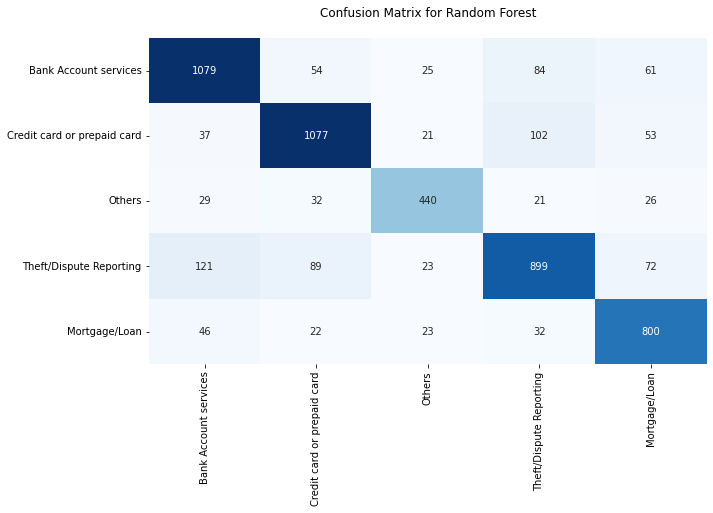

In [ ]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

In [ ]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94
1,Decision Tree,0.78,0.80
2,Random Forest,0.81,0.81


Model #4: Naive Bayes 

In [ ]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'Naive Bayes'
clf_nb = MultinomialNB()
%time 
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [ ]:
#Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.6843175872516123

In [ ]:
# Hyperparameter tuning to improve Naive Bayes performance
param_grid_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=clf_nb, 
                       param_grid=param_grid_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


Best Estimator parameters

{'alpha': 0.1, 'fit_prior': False}

In [ ]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.785515880365828

Classification Report for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.84      0.81      1303
Credit card or prepaid card       0.81      0.76      0.78      1290
                     Others       0.70      0.64      0.67       548
    Theft/Dispute Reporting       0.78      0.78      0.78      1204
              Mortgage/Loan       0.83      0.85      0.84       923

                   accuracy                           0.79      5268
                  macro avg       0.78      0.77      0.78      5268
               weighted avg       0.79      0.79      0.79      5268



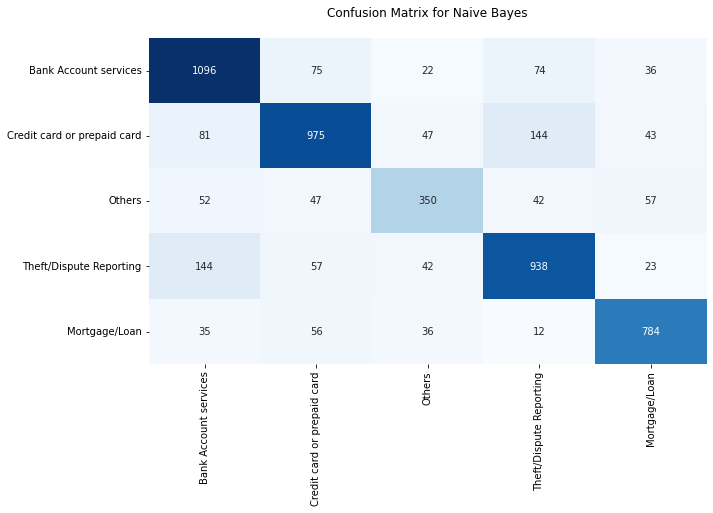

In [ ]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

 The tuned Naive Bayes model gives a moderately well F1 score of 0.78.
 However, this model performs a bit poor on classifying Others compared to remaining four topics.

In [ ]:
 # Update the summary table
summary.loc[len(summary.index)] = ['Naive Bayes', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94
1,Decision Tree,0.78,0.80
2,Random Forest,0.81,0.81
3,Naive Bayes,0.78,0.80


Model Inference

Now, we use this tuned Logistic Regression model - clf_lr_tuned to predict some new custom text.

In [ ]:
# Save tuned Logistic Regression model as pickle file
pickle.dump(clf_lr_tuned, open("logreg_model.pkl", "wb"))

In [ ]:
# Function to predict a topic for given text

def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
    loaded_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [ ]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and their locations in the city of Dubai


In [ ]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card or prepaid card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and their locations in the city of Dubai,Bank Account services


Thus, we can conclude that our model performs very well in classifying any new text.